## Import packages

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
import seaborn as sns
import pandas as pd
import pickle
import scanpy as sc
sc.set_figure_params(dpi=100, dpi_save=300)
import scvi
import anndata as ad
from matplotlib import pyplot, cm
import os
from math import ceil
from scipy.stats import spearmanr
import math

import leidenalg

from anndata import AnnData
import scanpy as sc
from scanpy import read
import pandas as pd
from sciPENN.Preprocessing import preprocess

import matplotlib.pyplot as plt
print(scvi.__version__)

Global seed set to 0


0.14.6


# Read data: Pbmc (train), H1N1 (test)

In [2]:
adata_gene = sc.read("../Data/pbmc/pbmc_gene.h5ad")
adata_protein = sc.read("../Data/pbmc/pbmc_protein.h5ad")

In [3]:
adata_gene_test = sc.read("../Data/H1N1/gene_data.mtx").T
adata_gene_test.var.index = pd.read_csv("../Data/H1N1/gene_names.txt", index_col = 0).iloc[:, 0]
adata_gene_test.obs = pd.read_csv("../Data/H1N1/meta_data.txt", sep = ',', index_col = 0)

In [4]:
adata_protein_test = sc.read("../Data/H1N1/protein_data.mtx").T
adata_protein_test.var.index = [x[:len(x) - 5] for x in pd.read_csv("../Data/H1N1/protein_names.txt", index_col = 0).iloc[:,0]]
adata_protein_test.obs = pd.read_csv("../Data/H1N1/meta_data.txt", sep = ',', index_col = 0)

adata_protein_test.layers["raw"] = adata_protein_test.X

# Selecting highly variable genes - using gene expression measures from test data 

In [5]:
gene_train, protein_train, gene_test, bools, train_keys, categories = preprocess([adata_gene], [adata_protein], adata_gene_test, train_batchkeys = ["donor"], test_batchkey = "sample", gene_list = [], select_hvg = True, cell_normalize = True, log_normalize = True, gene_normalize = True, min_cells = 30, min_genes = 200)


QC Filtering Training Cells
QC Filtering Testing Cells

QC Filtering Training Genes
QC Filtering Testing Genes

Normalizing Training Cells
Normalizing Testing Cells

Log-Normalizing Training Data
Log-Normalizing Testing Data

Finding HVGs


C:\Users\26074\.conda\envs\sciPENN\lib\site-packages\anndata\_core\anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
C:\Users\26074\.conda\envs\sciPENN\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)



Normalizing Gene Training Data by Batch


100%|██████████| 8/8 [00:07<00:00,  1.13it/s]



Normalizing Protein Training Data by Batch


100%|██████████| 8/8 [00:03<00:00,  2.39it/s]



Normalizing Gene Testing Data by Batch


100%|██████████| 20/20 [00:01<00:00, 11.79it/s]


In [6]:
hvg = gene_test.var_names
cells_test = gene_test.obs_names
cells_train = gene_train.obs_names

In [7]:
del gene_train
del gene_test
del protein_train

import gc
gc.collect()

4107

# Format data

In [8]:
# What proteins overlap between the test and train data?

train_protein = adata_protein.var_names
test_protein = adata_protein_test.var_names
overlap_protein = train_protein[train_protein.isin(test_protein)]

In [9]:
## Subsetting the data by the HVG - pbmc

adata_gene_pbmc_hvg = adata_gene[cells_train, hvg].copy()

In [10]:

## Subsetting the data by the HVG - h1n1

adata_gene_h1n1_hvg = adata_gene_test[cells_test, hvg].copy()

In [11]:
(adata_gene_pbmc_hvg.var.index == adata_gene_h1n1_hvg.var.index).mean()

1.0

In [12]:
adata_protein = adata_protein[cells_train, :].copy()
adata_protein_test = adata_protein_test[cells_test, :].copy()

In [13]:
# Batches (subject) in training data - pbmc (8 subjects)

adata_gene_pbmc_hvg.obs['patient'] = pd.DataFrame(adata_gene_pbmc_hvg.obs['donor']).copy()
adata_gene_pbmc_hvg.obs['patient'] = adata_gene_pbmc_hvg.obs['donor'].astype("str")

In [14]:
# Batches (subject) in test data - h1n1 (20 subjects)

adata_gene_h1n1_hvg.obs['patient'] = pd.DataFrame(adata_gene_h1n1_hvg.obs['sample']).copy()
adata_gene_h1n1_hvg.obs['patient'] = adata_gene_h1n1_hvg.obs['patient'].astype("str")

In [15]:
## Combine data

adata = ad.concat([adata_gene_pbmc_hvg.copy(), adata_gene_h1n1_hvg.copy()],
                     join='outer')

### Note: Train on PBMC

In [16]:
train_patients = adata.obs["patient"].unique()[0:8]

In [17]:
test_patients = adata.obs["patient"].unique()[8:]

# Subset data based on HVGs and Hold Out Test Protein Set

In [18]:
adata_final = adata.copy()

In [19]:
held_out_proteins = adata_protein_test[cells_test, overlap_protein].copy()

### Now we hold-out the proteins for the test patients dataset. To do so, we can replace all the values with 0s. We will store the original values to validate after training.

In [20]:
# Modified this code cell to predict all p = 224 proteins

n, p = adata_protein.shape
n_test, p_test = adata_protein_test.shape

protein_dat = pd.DataFrame(np.zeros(shape = (n + n_test, p), dtype = 'float32'), 
                           index = list(adata_protein.obs_names) + list(adata_protein_test.obs_names),
                           columns = adata_protein.var_names)

protein_dat.iloc[:n] = adata_protein.X.toarray().copy() #fill the protein training data, leave test data as 0s

adata_final.obsm["protein_expression"] = protein_dat


# Remove additional data from memory:

In [21]:
del adata_gene
del adata_protein
del adata_protein_test
del adata_gene_test
del adata_gene_pbmc_hvg
del adata

# Run TotalVI

In [22]:
scvi.data.setup_anndata(adata_final, batch_key="patient", 
                        protein_expression_obsm_key="protein_expression")

INFO     Using batches from adata.obs["patient"]                                                                   
INFO     No label_key inputted, assuming all cells have same label                                                 
INFO     Using data from adata.X                                                                                   


C:\Users\26074\.conda\envs\sciPENN\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.
  warnings.warn(msg, category=FutureWarning)


INFO     Using protein expression from adata.obsm['protein_expression']                                            
INFO     Using protein names from columns of adata.obsm['protein_expression']                                      
INFO     Found batches with missing protein expression                                                             
INFO     Successfully registered anndata object containing 214948 cells, 1000 vars, 28 batches, 1 labels, and 224  
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               
INFO     Please do not further modify adata until model is trained.                                                


In [23]:
scvi.data.view_anndata_setup(adata_final)

C:\Users\26074\.conda\envs\sciPENN\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function view_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


Anndata setup with scvi-tools version 0.14.6.

              Data Summary               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃             Data             ┃ Count  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│            Cells             │ 214948 │
│             Vars             │  1000  │
│            Labels            │   1    │
│           Batches            │   28   │
│           Proteins           │  224   │
│ Extra Categorical Covariates │   0    │
│ Extra Continuous Covariates  │   0    │
└──────────────────────────────┴────────┘

                   SCVI Data Registry                    
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Data        ┃       scvi-tools Location        ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         X          │             adata.X              │
│   batch_indices    │     adata.obs['_scvi_batch']     │
│       labels       │    adata.obs['_scvi_labels']     │
│ protein_expression │ adata.obsm['protein_expression'] │
└────────────────────┴──────────────────────────────────┘

                        Label Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                     Batch Categories                      
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['patient'] │   200_d0   │          0          │
│                      │   201_d0   │          1          │
│                      │   205_d0   │          2          │
│                      │   207_d0   │          3          │
│                      │   209_d0   │          4          │
│                      │   212_d0   │          5          │
│                      │   215_d0   │          6          │
│                      │   229_d0   │          7          │
│                      │   233_d0   │          8          │
│                      │   234_d0   │          9          │
│                      │   236_d0   │         10          │
│                      │   237_d0   │         11          │
│                      │   245_d0   │         12          │
│                      │   250_d0   │         13          │
│                      │   256_d0   │         14          │
│                      │   261_d0   │         15          │
│                      │   268_d0   │         16          │
│                      │   273_d0   │         17          │
│                      │   277_d0   │         18          │
│                      │   279_d0   │         19          │
│                      │     P1     │         20          │
│                      │     P2     │         21          │
│                      │     P3     │         22          │
│                      │     P4     │         23          │
│                      │     P5     │         24          │
│                      │     P6     │         25          │
│                      │     P7     │         26          │
│                      │     P8     │         27          │
└──────────────────────┴────────────┴─────────────────────┘

In [24]:
totalvae = scvi.model.TOTALVI(
    adata_final,
    latent_distribution = "normal",
    n_layers_decoder = 2)

INFO     Computing empirical prior initialization for protein background.                                          


C:\Users\26074\.conda\envs\sciPENN\lib\site-packages\scvi\model\_totalvi.py:124: UserWarning: Some proteins have all 0 counts in some batches. These proteins will be treated as missing measurements; however, this can occur due to experimental design/biology. Reinitialize the model with `override_missing_proteins=True`,to override this behavior.
  warnings.warn(msg, UserWarning)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 346/400:  86%|████████▋ | 346/400 [3:48:02<35:35, 39.55s/it, loss=388, v_num=1]


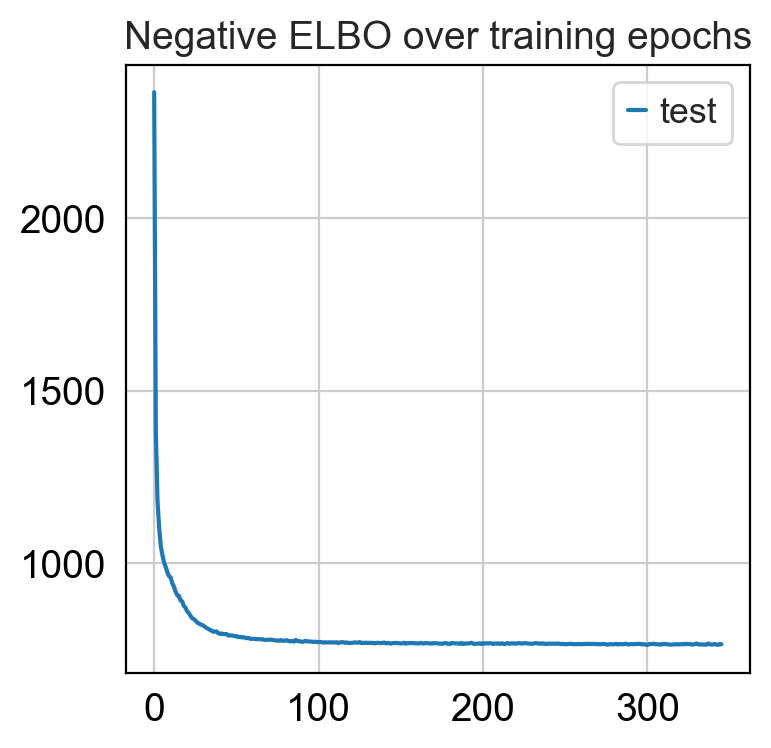

In [25]:
# Training with the default number of epochs 

# Training with the default number of epochs 
n_epochs = 400
lr = 4e-3

if os.path.isdir('weights_dir/totalvi_seurattoh1n1'):
    totalvae = totalvae.load("weights_dir/totalvi_seurattoh1n1", adata = adata_final)
else:
    totalvae.train(max_epochs=400)
    plt.plot(totalvae.history["elbo_validation"], label="test")
    plt.title("Negative ELBO over training epochs")
    plt.legend()
    
    totalvae.save("weights_dir/totalvi_seurattoh1n1")

# Analyze output - Results on training data

In [26]:
_, protein_means = totalvae.get_normalized_expression(
    transform_batch=train_patients,
    include_protein_background=True,
    sample_protein_mixing=False,
    return_mean=True,
)

#### Note that: transform_batch is a power parameter. Setting this allows one to predict the expression of cells as if they came from the inputted batch. In this case, we’ve observed protein expression in the training batchs “RPM211 and RPM232” (batch categories from original adata object), but we have no protein expression in the test batchs “RPM215 and RPM218”. We’d like to take the cells of the trainig batch and make a counterfactual prediction: “What would the expression look like if my batch "RPM211 and RPM232" cells came from batch “RPM215 and RPM218”?”

In [27]:
X_totalVI = pd.DataFrame(totalvae.get_latent_representation(), index = adata_final.obs.index)
X_totalVI.to_csv("totalvi_pbmctoh1n1embedding.csv")

# Imputed protein expression: 

In [28]:
true_protein_test = pd.DataFrame(held_out_proteins.X.toarray(), index = held_out_proteins.obs.index, columns = held_out_proteins.var.index)

In [29]:
imputed_pros = protein_means[adata_final.obs.patient.isin(test_patients)]

pat_names = adata_final.obs['patient'].isin(test_patients)
patients = adata_final.obs.patient[pat_names].values
imputed_proteins_test = imputed_pros[overlap_protein] # Subset totalvi output to only include overlapping proteins

In [30]:
def corr2_coeff(A, B, pearson = True):
    if pearson:
        # Rowwise mean of input arrays & subtract from input arrays themeselves
        A_mA = A - A.mean(1)[:, None]
        B_mB = B - B.mean(1)[:, None]

        # Sum of squares across rows
        ssA = (A_mA**2).sum(1)
        ssB = (B_mB**2).sum(1)

        # Finally get corr coeff
        corr_mat = np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None],ssB[None]))
        
        return corr_mat[range(corr_mat.shape[0]), range(corr_mat.shape[0])]
    
    else:
        corrs = [0.] * A.shape[0]
        
        for i in range(A.shape[0]):
            corrs[i] = spearmanr(A[i], B[i])[0]
            
        return corrs

In [31]:
cells, proteins = imputed_proteins_test.index, imputed_proteins_test.columns

In [32]:
# Normalize totalvi output, and gold standard counts

true_protein_test = AnnData(true_protein_test)
imputed_proteins_test = AnnData(imputed_proteins_test)

sc.pp.normalize_total(true_protein_test)
sc.pp.log1p(true_protein_test)

sc.pp.normalize_total(imputed_proteins_test)
sc.pp.log1p(imputed_proteins_test)

for patient in test_patients:
    indices = [x == patient for x in patients]
    sub_adata = imputed_proteins_test[indices]
    sc.pp.scale(sub_adata)
    imputed_proteins_test[indices] = sub_adata.X
    
    sub_adata = true_protein_test[indices]
    sc.pp.scale(sub_adata)
    true_protein_test[indices] = sub_adata.X
    
true_protein_test = pd.DataFrame(true_protein_test.X, index = cells, columns = proteins)
imputed_proteins_test = pd.DataFrame(imputed_proteins_test.X, index = cells, columns = proteins)

C:\Users\26074\.conda\envs\sciPENN\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [33]:
sq = lambda x, y: (x - y)**2

In [34]:
corrs_table = np.zeros((imputed_proteins_test.shape[1], len(np.unique(patients))))
sq_table = corrs_table.copy()

for i, patient in enumerate(np.unique(patients)):
    truth = true_protein_test[patients == patient].to_numpy()
    imputed = imputed_proteins_test[patients == patient].to_numpy()

    corrs_table[:, i] = corr2_coeff(truth.T, imputed.T)
    sq_table[:, i] = sq(truth, imputed).mean(axis = 0)

if np.isnan(corrs_table).sum() > 0:
    corrs_table[np.isnan(corrs_table)] = 0
    
corrs_table = pd.DataFrame(corrs_table)
sq_table = pd.DataFrame(sq_table)
corrs_table.index, corrs_table.columns = imputed_proteins_test.columns, np.unique(patients)
sq_table.index, sq_table.columns = imputed_proteins_test.columns, np.unique(patients)

In [35]:
#here are correlations

corrs_table.mean()

200_d0    0.529991
201_d0    0.535947
205_d0    0.541014
207_d0    0.528321
209_d0    0.537711
212_d0    0.530270
215_d0    0.549323
229_d0    0.547819
233_d0    0.535824
234_d0    0.566805
236_d0    0.519249
237_d0    0.516355
245_d0    0.515567
250_d0    0.524233
256_d0    0.553616
261_d0    0.522329
268_d0    0.548493
273_d0    0.500887
277_d0    0.532409
279_d0    0.523650
dtype: float64

In [36]:
#here are correlations
corrs_table.mean().mean()

0.532990590010494

In [37]:
corrs_table.to_csv('corrs_results/totalvi_pbmctoh1n1.csv')

In [38]:
sq_table.mean()

200_d0    0.939698
201_d0    0.927669
205_d0    0.917780
207_d0    0.943028
209_d0    0.924270
212_d0    0.939181
215_d0    0.901016
229_d0    0.903860
233_d0    0.927871
234_d0    0.865977
236_d0    0.960806
237_d0    0.966936
245_d0    0.968479
250_d0    0.951081
256_d0    0.892393
261_d0    0.954920
268_d0    0.902764
273_d0    0.997928
277_d0    0.934849
279_d0    0.952322
dtype: float64

In [39]:
sq_table.mean().mean()

0.9336413932553793

In [40]:
sq_table.to_csv('mse_results/totalvi_pbmctoh1n1.csv')

In [41]:
imputed_proteins_test.to_csv('totalvi_pbmctoh1n1features.csv')